# How to predict with missing values ?

In this tutorial, we will cover how to accurately predict the response `y` given `X` when `X` contains missing values.

In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

# 1 Get your data (with missing values)

In [2]:
# Load you data here

from sklearn.datasets import fetch_california_housing
X_complete, y = fetch_california_housing(return_X_y = True)

In [3]:
# Artificially add some np.nan

np.random.seed(1)  # fix the seed

def ampute_mcar(X_complete, y=None):
    # Add completly at random missing values
    
    X = X_complete.copy()
    missing_mask = np.random.binomial(1, .2, X.shape)
    np.putmask(X, missing_mask, np.nan)
    return X

def ampute_mnar(X_complete, y=None):
    # Add missing values not at random
    
    X = X_complete.copy()
    ## Add censored missing values
    missing_mask = (np.random.normal(X_complete) > X_complete + 1)
    np.putmask(X, missing_mask, np.nan)

    if y is not None:
        ## Add missing values correlated with y
        y_max = np.percentile(y, 90)
        y_max_mask = y >= y_max
        np.putmask(X[:,2], y_max_mask, np.nan)
        
    return X

In [4]:
X_mcar = ampute_mcar(X_complete)
X_mnar = ampute_mnar(X_complete, y)
X = X_mcar

### Quick Exploratory Data Analysis

Few lines of code to appreciate the missingness in our data

In [5]:
print('Shape of X:', X.shape)

Shape of X: (20640, 8)


In [6]:
np.set_printoptions(precision=4, suppress=True) #  supress scientific notation 
(X[:5])

array([[   8.3252,   41.    ,    6.9841,    1.0238,  322.    ,    2.5556,
          37.88  , -122.23  ],
       [   8.3014,   21.    ,    6.2381,    0.9719, 2401.    ,       nan,
          37.86  , -122.22  ],
       [   7.2574,   52.    ,    8.2881,    1.0734,       nan,       nan,
          37.85  , -122.24  ],
       [      nan,       nan,    5.8174,    1.0731,  558.    ,       nan,
          37.85  , -122.25  ],
       [      nan,   52.    ,    6.2819,    1.0811,  565.    ,       nan,
          37.85  , -122.25  ]])

In [7]:
print('Ratio nan in X:', np.round(100 * np.sum(np.isnan(X)) / X.size,1), '%')
print('Ratio nan in y:', np.round(100 * np.sum(np.isnan(y)) / y.size,1), '%')

Ratio nan in X: 20.0 %
Ratio nan in y: 0.0 %


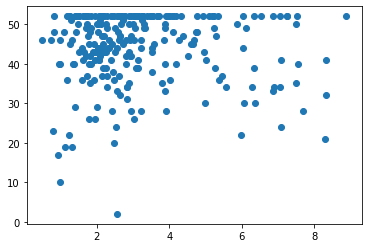

In [8]:
plt.scatter(X[:400,0], X[:400,1]);  #  data with missing coordinate are not plotted

# 2 Imputation Model

Our goal is to predict `y` as accurately as possible. 
There exists mainly two options to deal with missing values:
1. Either we get rid of all missing values (ease of use at the price of loosing information);
2. Or we impute the missing values.  

We will describe the second option in details.

## Imputation strategies

Since there is no prefer way to deal with missing values, we will consider three imputation strategies:
1. Mean imputation: replace `nan` by the mean [or the median] of the feature (the column);
2. Iterative imputation: each feature is regressed/estimated from the others;
3. MinMax Imputation (also refer as Missing In Attribute, by [Twala et al.](https://www.sciencedirect.com/science/article/pii/S0167865508000305)): duplicating features twice and replace its missing values once by $\infty$ and once by $- \infty$. 

In the case of Mean or Iterative imputation, it might by fruitfull to add the missing values indicator (by concatenating the missing indicator to $X$)

__Rule of thumb__: If we possess a good learner algorithm and enough samples in our dataset (e.g. more than $10^5$), the mean imputation is a good default choice (since it is consistent).

In [9]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')
X_impute = imputer.fit_transform(X)
print(X_impute[:5])

[[   8.3252   41.        6.9841    1.0238  322.        2.5556   37.88
  -122.23  ]
 [   8.3014   21.        6.2381    0.9719 2401.        3.1038   37.86
  -122.22  ]
 [   7.2574   52.        8.2881    1.0734 1428.183     3.1038   37.85
  -122.24  ]
 [   3.8718   28.674     5.8174    1.0731  558.        3.1038   37.85
  -122.25  ]
 [   3.8718   52.        6.2819    1.0811  565.        3.1038   37.85
  -122.25  ]]


In [10]:
print('Ratio nan =', np.round(100 * np.sum(np.isnan(X_impute)) / X.size,1), '%')

Ratio nan = 0.0 %


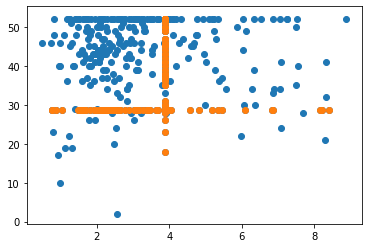

In [11]:
plt.scatter(X_impute[:400,0], X_impute[:400,1])

missing_mask = np.where([any(x) for x in np.isnan(X[:400][:,[0,1]])])
plt.scatter(X_impute[missing_mask,0], X_impute[missing_mask,1])

In [12]:
# explicitly require because IterativeImputer is still experimental in sklearn
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

imputer = IterativeImputer()
X_impute = imputer.fit_transform(X)
print(X_impute[:5])

[[   8.3252   41.        6.9841    1.0238  322.        2.5556   37.88
  -122.23  ]
 [   8.3014   21.        6.2381    0.9719 2401.        9.2866   37.86
  -122.22  ]
 [   7.2574   52.        8.2881    1.0734  408.2665    0.8595   37.85
  -122.24  ]
 [   4.5338   33.2761    5.8174    1.0731  558.       -3.1331   37.85
  -122.25  ]
 [   4.824    52.        6.2819    1.0811  565.        1.3492   37.85
  -122.25  ]]


/home/nicolas/anaconda3/lib/python3.6/site-packages/sklearn/impute/_iterative.py:603: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


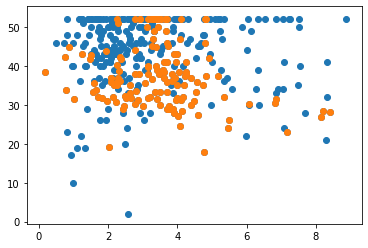

In [13]:
plt.scatter(X_impute[:400,0], X_impute[:400,1])

missing_mask = np.where([any(x) for x in np.isnan(X[:400][:,[0,1]])])
plt.scatter(X_impute[missing_mask,0], X_impute[missing_mask,1]);

Imputation here takes advantage of others features.

# 3. Simulations/Experiments

Let's evaluate the differents imputation strategies.
Let's consider our differents imputers w.r.t. differents machine learning algorithms. The pipeline will be 
- 1. Imputation
- 2. Regression on the imputed dataset  

### 3.1 Step by step pipeline with LinearRegression()
Here we decompose each step of the pipeline for clarity.

In [14]:
# First split the data into train set and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)
print('train shape: X.shape={}, y.shape={}'.format(X_train.shape, y_train.shape))
print('test shape: X.shape={}, y.shape={}'.format(X_test.shape, y_test.shape))

train shape: X.shape=(15480, 8), y.shape=(15480,)
test shape: X.shape=(5160, 8), y.shape=(5160,)


In [15]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()

In [16]:
""" Line below would raise an ValueError: 
'Input contains NaN, infinity or a value too large for dtype('float64').'
Because LinearRegressor couldn't deals with NaN values.""";

# regressor.fit(X_train, y_train) 

In [17]:
# Good practice are: fitting on the train, then transform both train and test with the *same* imputer

imputer = SimpleImputer(strategy='mean')
imputer.fit(X_train)

X_train_imp = imputer.transform(X_train)
X_test_imp = imputer.transform(X_test)

In [18]:
regressor.fit(X_train_imp, y_train)
print('Score on train:', regressor.score(X_train_imp, y_train))
print('Score on test:', regressor.score(X_test_imp, y_test))

Score on train: 0.43620914183706777
Score on test: 0.4264164447205786


In [19]:
# Try with the IterativeImputer now
imputer_it = IterativeImputer()
imputer_it.fit(X_train)

X_train_imp_it = imputer_it.transform(X_train)
X_test_imp_it = imputer_it.transform(X_test)

regressor.fit(X_train_imp_it, y_train)
print('Score on train:', regressor.score(X_train_imp_it, y_train))
print('Score on test:', regressor.score(X_test_imp_it, y_test))

Score on train: 0.5016123112292037
Score on test: 0.48840890705990336


/home/nicolas/anaconda3/lib/python3.6/site-packages/sklearn/impute/_iterative.py:603: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


Here we see that the Iterative imputation method can add information for Linear Regression method.  

### 3.2 Model selection

Now we run our pipeline on severals imputers and regressors.  
We will use `Pipeline` from sklearn to sequentially apply imputation and regression.  
We finally use sklearn cross_val_score to evaluate our models.

In [20]:
# Imputer model:

from sklearn.preprocessing import MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin

class MinMaxImputer(BaseEstimator, TransformerMixin):
    # replacing the `nan` by two extremes values (by duplicating each column)
    
    def fit(self, X, y=None):
        mm = MinMaxScaler().fit(X)
        self.data_min_ = mm.data_min_
        self.data_max_ = mm.data_max_
        return self

    def transform(self, X):
        X_min, X_max = X.copy(), X.copy()

        for feature_idx in range(X.shape[1]):
            nan_mask = np.isnan(X[:, feature_idx])
            X_min[nan_mask, feature_idx] = self.data_min_[feature_idx] - 1
            X_max[nan_mask, feature_idx] = self.data_max_[feature_idx] + 1

        return np.concatenate([X_min, X_max], axis=1)
    
imputers_wo_indicator = {'Simple': SimpleImputer(add_indicator=False),
                         'Iterative': IterativeImputer(add_indicator=False)}
imputers_with_indicator = {'Simple': SimpleImputer(add_indicator=True),
                           'Iterative': IterativeImputer(add_indicator=True),
                           'MinMax': MinMaxImputer()}

In [21]:
# Regressor model:

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor  # similar to XGBoost/lightGBM

regressors = {'LinReg': LinearRegression(),
#               'SVM': SVR(C=100),
              'RandomForest': RandomForestRegressor(),
              "HGBoost": HistGradientBoostingRegressor()}

In [22]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import ShuffleSplit, cross_val_score

def plot_score_regressor(X, y, regressor, regressor_name='regressor', X_complete=None):
    # Boxplot scores for each imputation strategies
    
    l_score = []
    for imputers in [imputers_wo_indicator, imputers_with_indicator]:
        for imputer_name, imputer in imputers.items():
            pipeline = Pipeline([(imputer_name, imputer), (regressor_name, regressor)])
            score = cross_val_score(pipeline, X, y, n_jobs=-1, cv = 5)
            l_score.append(score)
            
    score_ground_truth = cross_val_score(regressor, X_complete, y, n_jobs=-1, cv = 5)
    l_score.append(score_ground_truth)
    plt.title(regressor_name)     
    labels = ['Simple', 'Iterative', 'Simple+Mask', 'Iterative+Mask', 'MinMax', 'X_complete']
    bplot = plt.boxplot(l_score[::-1], labels=labels[::-1],
                vert=False, patch_artist=True)

    # Add colors to boxplots
    for patch, color in zip(bplot['boxes'],
                            ['C0','C1','C2','C3', 'C4', 'C5']):
        patch.set_facecolor(color)


/home/nicolas/anaconda3/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


CPU times: user 1.21 s, sys: 165 ms, total: 1.38 s
Wall time: 6min 46s


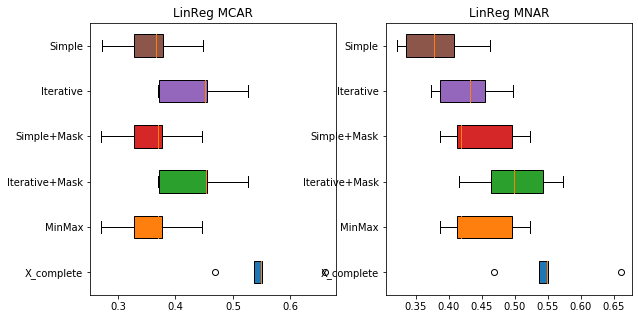

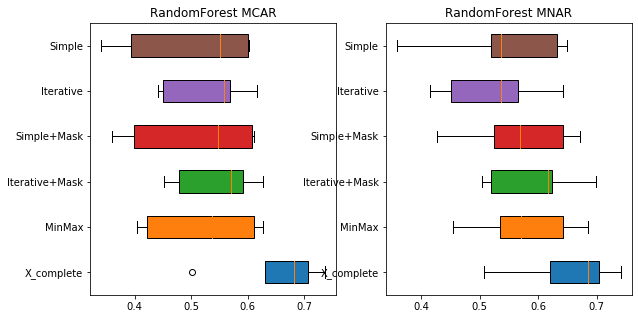

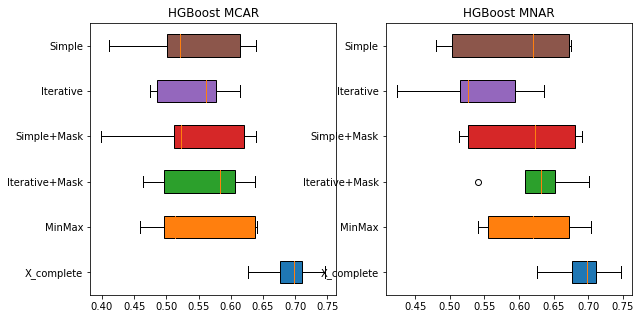

In [23]:
%%time
for regressor_name, regressor in regressors.items():
    plt.figure(figsize=(15,5))
    for ii, (X, X_name) in enumerate(zip([X_mcar, X_mnar], ['MCAR', 'MNAR'])):
        plt.subplot(1, 3, ii+1)
        plot_score_regressor(X, y, regressor, regressor_name + ' ' + X_name, X_complete)

Note that in the HistGradientBoostedTree, MIA (i.e. replacing the `np.nan` by the two extremes values, by duplicating each column containing `np.nan`) will be implemented by default in the next release of sklearn in [HistGradientBoostedTree](https://scikit-learn.org/dev/modules/generated/sklearn.ensemble.HistGradientBoostingClassifier.html)

# Summary

- To train and test on data with missing values, the **same imputation model should be used**.

- *Missing Incorporated in Attribute (MIA)* is a good solution for tree-based models (e.g. lightGBM implementation, sklearn next release). It handles missing values information.   

- Imputation methods *reduce* the number of samples required to reach good prediction

- When missingness is related to the prediction target, it is useful to *add indicator of missing entries as features*


### Further reading


- Pandas contains some functions to deals with `nan`: [Missing data with Pandas](https://pandas.pydata.org/pandas-docs/stable/user_guide/missing_data.html)
- [Impuation in sklearn](https://scikit-learn.org/stable/modules/impute.html)
    - Here we used both the [SimpleImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html) and the [IterativeImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html) class.